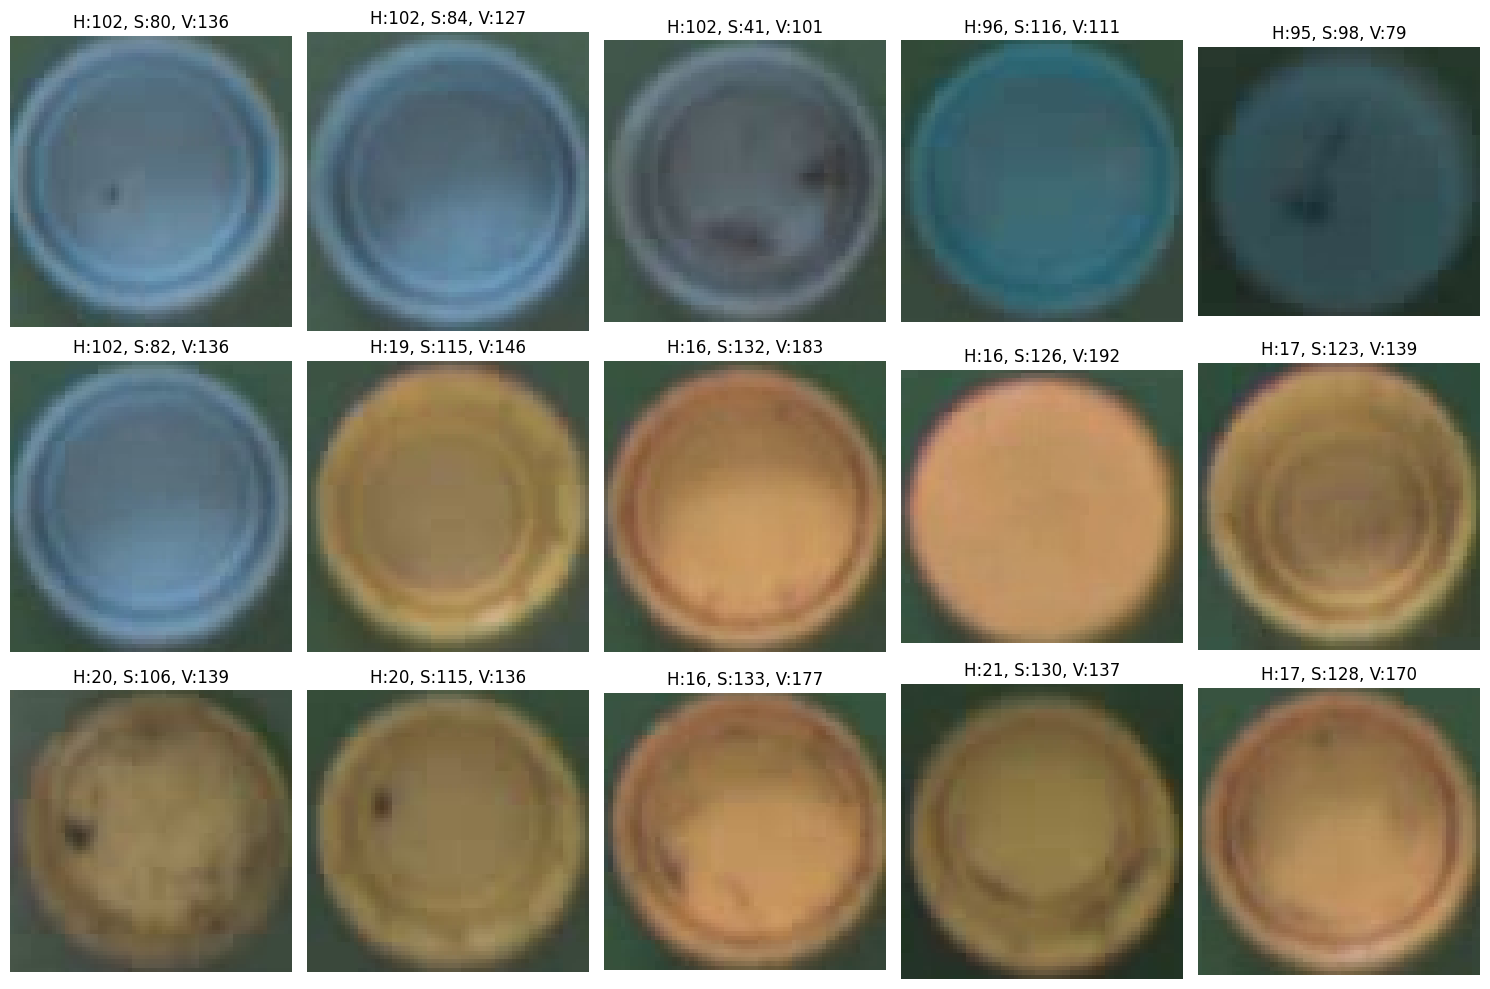

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ambil beberapa sampel gambar dari folder train
image_files = glob.glob("../datasets/bottle_cap/train/images/*.jpg")[:5] # Ambil 3 gambar saja dulu

def get_hsv_stats(img_path, label_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, w, _ = img.shape
    
    crops = []
    stats = []
    
    if not os.path.exists(label_path): return [], []
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        # Koordinat YOLO
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Pastikan koordinat valid
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        # Ambil crop (potongan gambar tutup botol)
        crop_rgb = img_rgb[y1:y2, x1:x2]
        crop_hsv = img_hsv[y1:y2, x1:x2]
        
        if crop_rgb.size == 0: continue
            
        # Ambil bagian tengah saja (50%) untuk hindari background
        cy, cx = crop_hsv.shape[:2]
        center_hsv = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        # Hitung rata-rata H, S, V
        mean_h = np.mean(center_hsv[:,:,0]) # Hue (0-179 di OpenCV)
        mean_s = np.mean(center_hsv[:,:,1]) # Saturation (0-255)
        mean_v = np.mean(center_hsv[:,:,2]) # Value (0-255)
        
        crops.append(crop_rgb)
        stats.append((mean_h, mean_s, mean_v))
        
    return crops, stats

# Visualisasi
plt.figure(figsize=(15, 10))
k = 1
for img_file in image_files:
    lbl_file = img_file.replace('images', 'labels').replace('.jpg', '.txt')
    crops, stats = get_hsv_stats(img_file, lbl_file)
    
    for crop, stat in zip(crops, stats):
        if k > 15: break # Jangan kebanyakan plot
        plt.subplot(3, 5, k)
        plt.imshow(crop)
        plt.title(f"H:{stat[0]:.0f}, S:{stat[1]:.0f}, V:{stat[2]:.0f}")
        plt.axis('off')
        k += 1

plt.tight_layout()
plt.show()

Menganalisis 12 gambar... Mohon tunggu.


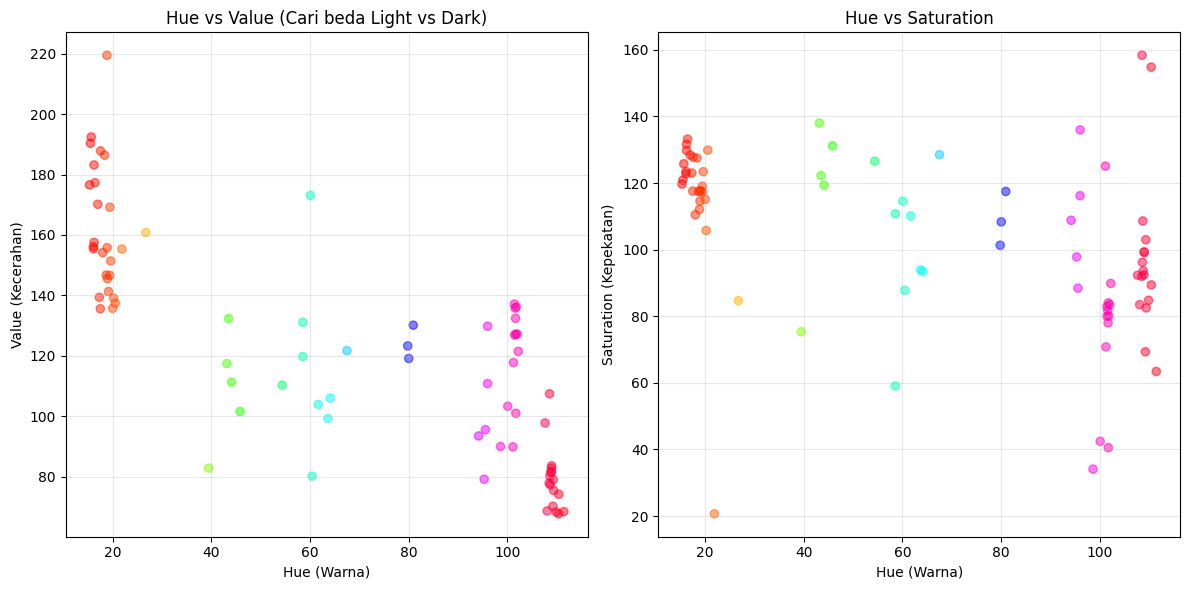

Total Tutup Botol terdeteksi: 79


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Ambil SEMUA gambar di folder train dan valid
train_images = glob.glob("../datasets/bottle_cap/train/images/*.jpg")
val_images = glob.glob("../datasets/bottle_cap/valid/images/*.jpg")
all_images = train_images + val_images

h_values = []
s_values = []
v_values = []

print(f"Menganalisis {len(all_images)} gambar... Mohon tunggu.")

for img_path in all_images:
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    if not os.path.exists(label_path): continue
    
    img = cv2.imread(img_path)
    if img is None: continue
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_img, w_img, _ = img.shape
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert ke pixel
        x1 = int((x_c - bw/2) * w_img)
        y1 = int((y_c - bh/2) * h_img)
        x2 = int((x_c + bw/2) * w_img)
        y2 = int((y_c + bh/2) * h_img)
        
        # Crop dan ambil tengahnya
        crop_hsv = img_hsv[y1:y2, x1:x2]
        if crop_hsv.size == 0: continue
            
        # Ambil area tengah 50% untuk akurasi warna
        cy, cx = crop_hsv.shape[:2]
        center = crop_hsv[int(cy*0.25):int(cy*0.75), int(cx*0.25):int(cx*0.75)]
        
        if center.size == 0: continue # Skip jika crop terlalu kecil

        h_val = np.mean(center[:,:,0])
        s_val = np.mean(center[:,:,1])
        v_val = np.mean(center[:,:,2])
        
        h_values.append(h_val)
        s_values.append(s_val)
        v_values.append(v_val)

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Hue vs Value (Biasanya untuk membedakan Light vs Dark)
plt.subplot(1, 2, 1)
plt.scatter(h_values, v_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Value (Kecerahan)')
plt.title('Hue vs Value (Cari beda Light vs Dark)')
plt.grid(True, alpha=0.3)

# Plot 2: Hue vs Saturation (Cari beda Warna Lain)
plt.subplot(1, 2, 2)
plt.scatter(h_values, s_values, alpha=0.5, c=h_values, cmap='hsv')
plt.xlabel('Hue (Warna)')
plt.ylabel('Saturation (Kepekatan)')
plt.title('Hue vs Saturation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total Tutup Botol terdeteksi: {len(h_values)}")

Menampilkan sampel LIGHT BLUE (Class 0)...


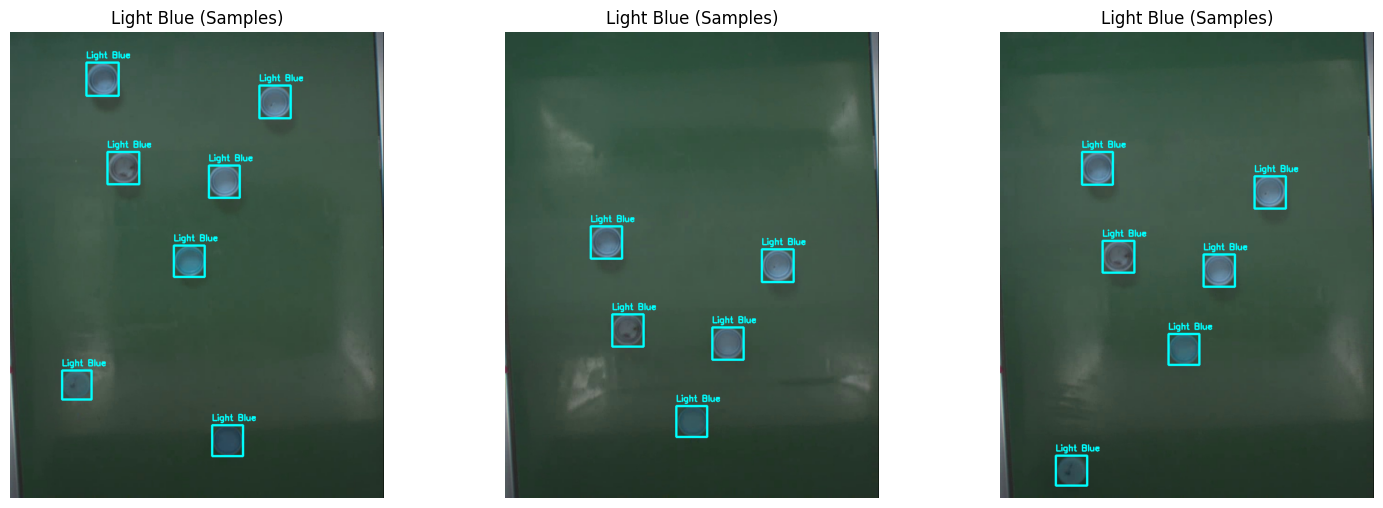

In [3]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import random

# Fungsi Helper untuk menampilkan gambar spesifik per kelas
def show_class_examples(target_class_id, class_name, bbox_color):
    # Cari semua file label di folder train
    label_files = glob.glob("../datasets/bottle_cap/train/labels/*.txt")
    
    found_images = []
    
    # Acak biar gak itu-itu aja yang tampil
    random.seed(42)
    random.shuffle(label_files)
    
    for lbl_path in label_files:
        if len(found_images) >= 6: break # Cukup tampilkan 6 gambar
        
        # Cek apakah di file ini ada class yang dicari
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            
        bboxes = []
        has_target = False
        
        for line in lines:
            parts = line.strip().split()
            cls_id = int(parts[0])
            
            # Hanya ambil kotak yang sesuai kategori target
            if cls_id == target_class_id:
                bboxes.append(list(map(float, parts[1:])))
                has_target = True
                
        if has_target:
            # Load gambar
            img_path = lbl_path.replace('labels', 'images').replace('.txt', '.jpg')
            if not os.path.exists(img_path): continue
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape
            
            # Gambar kotak
            for box in bboxes:
                xc, yc, bw, bh = box
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                
                cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, 3)
                cv2.putText(img, class_name, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)
            
            found_images.append(img)
    
    # Plotting
    if not found_images:
        print(f"Tidak ditemukan sampel untuk kelas: {class_name}")
        return

    plt.figure(figsize=(15, 10))
    for i, img in enumerate(found_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{class_name} (Samples)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- EKSEKUSI LIGHT BLUE ---
print("Menampilkan sampel LIGHT BLUE (Class 0)...")
# Warna Kotak: Cyan (0, 255, 255)
show_class_examples(0, "Light Blue", (0, 255, 255))

Menampilkan sampel DARK BLUE (Class 1)...


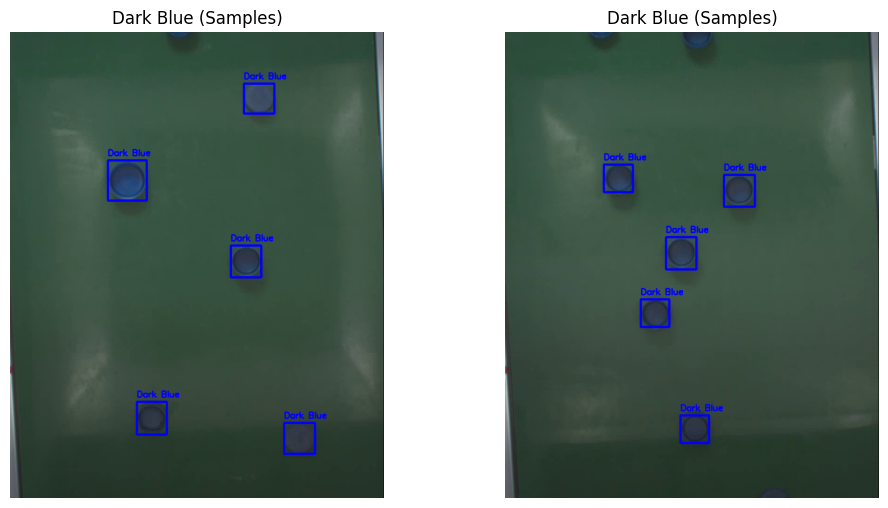

In [4]:
# --- EKSEKUSI DARK BLUE ---
print("Menampilkan sampel DARK BLUE (Class 1)...")
# Warna Kotak: Biru Tua (0, 0, 255) - Di matplotlib jadi Biru
show_class_examples(1, "Dark Blue", (0, 0, 255))

Menampilkan sampel OTHERS (Class 2)...


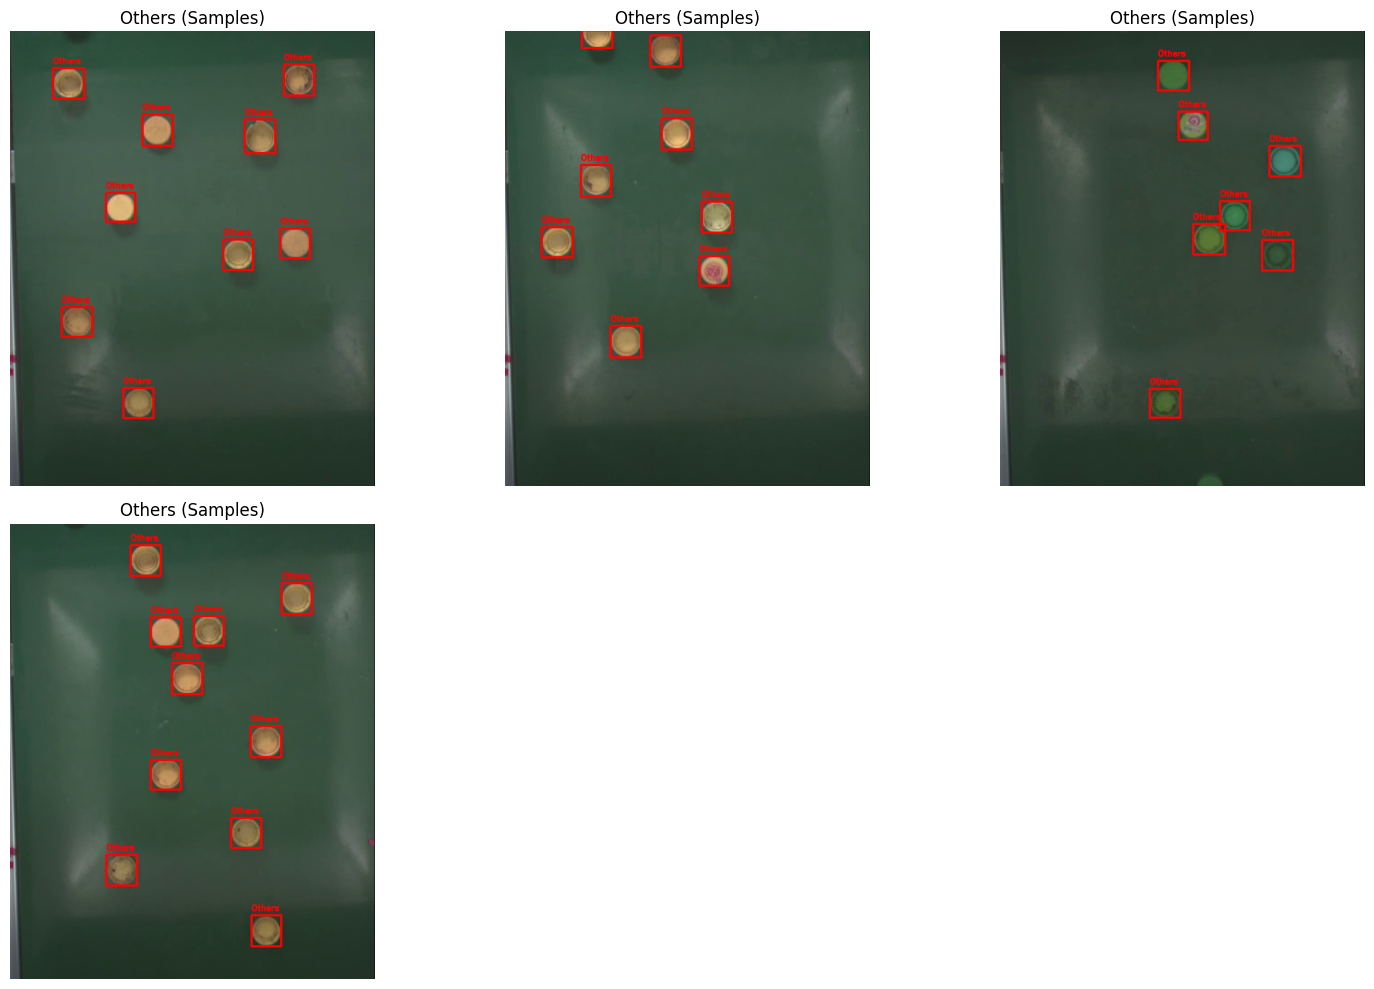

In [5]:
# --- EKSEKUSI OTHERS ---
print("Menampilkan sampel OTHERS (Class 2)...")
# Warna Kotak: Merah (255, 0, 0)
show_class_examples(2, "Others", (255, 0, 0))

In [6]:
import yaml
import os

# Path absolut biar aman
dataset_root = os.path.abspath("../datasets/bottle_cap")

data_yaml_content = {
    'path': dataset_root,  # Root folder dataset
    'train': 'train/images', # Lokasi data latih (relatif terhadap 'path')
    'val': 'valid/images',   # Lokasi data validasi
    
    # Definisi Kelas (Harus urut sesuai ID 0, 1, 2)
    'names': {
        0: 'light_blue',
        1: 'dark_blue',
        2: 'others'
    }
}

# Simpan ke file data.yaml di dalam folder dataset
yaml_path = os.path.join(dataset_root, "data.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=False)

print(f"File konfigurasi siap di: {yaml_path}")

File konfigurasi siap di: G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\datasets\bottle_cap\data.yaml


In [7]:
import wandb
from ultralytics import YOLO

# Login ke WandB (Nanti akan muncul input box untuk API Key)
wandb.login()

# Inisialisasi Project
wandb.init(project="ada-mata-bottle-cap", name="experiment-1-yolov8n")

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\LENOVO\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\LENOVO\_netrc
wandb: Currently logged in as: wikan (wikan-project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
from ultralytics import YOLO

# 1. Load Model (Otak kosong tapi pintar, versi Nano)
model = YOLO('yolov8n.pt') 

# 2. Mulai Training (Ini proses belajarnya)
results = model.train(
    data='../datasets/bottle_cap/data.yaml', # Pastikan path ini benar
    epochs=50,        # Latihan 50 kali putaran
    imgsz=640,        # Ukuran gambar
    batch=8,          # Sekali belajar 8 gambar
    project="runs/train", 
    name="exp_final", # Nama folder hasil
    device="cpu",     # Pakai CPU laptop
    plots=True        # Buatkan grafik otomatis
)

Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/bottle_cap/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

In [10]:
# Validasi model terbaik yang baru saja dilatih
metrics = model.val()

print("\n=== HASIL EVALUASI ===")
print(f"mAP@50 (Akurasi Umum): {metrics.box.map50:.2%}")
print(f"mAP@50-95 (Akurasi Ketat): {metrics.box.map:.2%}")

Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 1.00.4 ms, read: 2.80.8 MB/s, size: 41.5 KB)
val: Scanning G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\datasets\bottle_cap\valid\labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3/3 1.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.3it/s 0.2s
                   all          3         17       0.97      0.879      0.987      0.875
             dark_blue          1          7          1      0.858      0.995       0.87
                others          2         10      0.939        0.9      0.978       0.88
Speed: 1.2ms preprocess, 56.0ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning En

In [11]:
# Export model ke format ONNX
# format='onnx' -> Tipe file
# dynamic=False -> Ukuran gambar fix (biasanya lebih cepat untuk hardware tertentu)
# opset=12 -> Versi ONNX yang stabil
success = model.export(format='onnx', dynamic=False, opset=12)

print(f"Export berhasil? {success}")
# File akan tersimpan sebagai 'yolov8n.onnx' di folder runs/train/exp.../weights/

Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ----- ---------------------------------- 2.4/16.5 MB 16.8 MB/s eta 0:00:01
   ------ --------------------------------- 2.6/16.5 MB 8.9 MB/s eta 0:00:02
   -------- ------------------------------- 3.4/16.5 MB 5.9 MB/s eta 0:00:03
   -------- ------------------------------- 3.7/16.5 MB 5.1 MB/s eta 0:00:03
   --------- ------------

In [12]:
import time
import onnxruntime as ort
import numpy as np

# Cari lokasi file ONNX yang baru diexport
# Biasanya ada di runs/train/exp/weights/best.onnx
# Ganti path ini jika nama foldermu beda (misal exp2, exp3)
onnx_model_path = model.export(format='onnx') # Ini akan return path file-nya

# Load Model ONNX
session = ort.InferenceSession(onnx_model_path)
input_name = session.get_inputs()[0].name

# Buat dummy image (data bohong-bohongan) untuk tes kecepatan
# Ukuran 640x640, 3 warna (RGB), Batch 1
dummy_input = np.random.randn(1, 3, 640, 640).astype(np.float32)

print("Mulai Benchmark Kecepatan ONNX...")

# Pemanasan dulu (Warmup)
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Beneran (Loop 100 kali)
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

avg_time = (end_time - start_time) / 100 * 1000 # convert ke ms
print(f"\nRata-rata waktu inferensi ONNX: {avg_time:.2f} ms")

if avg_time <= 10:
    print("✅ MASUK TARGET (<= 10ms)!")
else:
    print(f"⚠️ SEDIKIT DI ATAS TARGET. ({avg_time:.2f}ms)")
    print("Note: Di laptop biasanya lebih lambat dari dedicated hardware, atau perlu GPU.")

Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)

PyTorch: starting from 'G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  2.5s, saved as 'G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.onnx' (11.7 MB)

Export complete (3.0s)
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights
Predict:         yolo predict task=detect model=G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=G:\My Drive\We Work Th

In [13]:
import time
import onnxruntime as ort
import numpy as np

# 1. Export ke ONNX (Format ringan)
print("Sedang meng-export model ke ONNX...")
success = model.export(format='onnx', dynamic=False, opset=12)

# 2. Cari file hasil export
# Biasanya tersimpan di folder yang sama dengan best.pt
# Kita ambil path-nya dari object model langsung biar gak salah
onnx_path = str(model.trainer.best).replace('.pt', '.onnx')
print(f"Model ONNX tersimpan di: {onnx_path}")

# 3. Benchmark Kecepatan
print("\nMulai Benchmark Kecepatan ONNX...")
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name

# Buat data dummy (Pura-pura jadi gambar)
dummy_input = np.random.randn(1, 3, 640, 640).astype(np.float32)

# Pemanasan
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

avg_time = (end_time - start_time) / 100 * 1000 # ke milidetik
print(f"\n=== HASIL AKHIR ===")
print(f"Rata-rata waktu inferensi ONNX: {avg_time:.2f} ms")

if avg_time <= 15: # Di laptop biasanya agak lebih pelan dari dedicated device
    print("🚀 NGEBUT! Sangat mungkin mencapai 5-10ms di Raspberry Pi 5 (karena ada NPU/Optimization).")
else:
    print("⚠️ Masih agak berat. Nanti kita coba kecilkan ukuran gambar (imgsz).")

Sedang meng-export model ke ONNX...
Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)

PyTorch: starting from 'G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 12...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  1.5s, saved as 'G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.onnx' (11.7 MB)

Export complete (1.8s)
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights
Predict:         yolo predict task=detect model=G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights\best.onnx imgsz=640  
Validate:        yolo val task

In [14]:
import time
import onnxruntime as ort
import numpy as np

# 1. Load lagi model training terakhir kita
model = YOLO('runs/train/exp_final/weights/best.pt') 

# 2. Export Khusus Versi Speed (320x320)
print("⏳ Sedang meng-export model versi 320px...")
# Kita ubah imgsz menjadi 320
success = model.export(format='onnx', dynamic=False, imgsz=320, opset=12)

# Ambil path file barunya (biasanya tersimpan dengan nama best.onnx juga, menimpa yang lama, atau di folder sama)
# Untuk amannya kita set manual path-nya karena kita tahu lokasinya
onnx_path_320 = "runs/train/exp_final/weights/best.onnx" 

# 3. Benchmark Lagi
print("\n🏎️ Mulai Benchmark (Ukuran 320x320)...")
session = ort.InferenceSession(onnx_path_320)
input_name = session.get_inputs()[0].name

# Dummy input harus disesuaikan ukurannya jadi 320
dummy_input = np.random.randn(1, 3, 320, 320).astype(np.float32)

# Pemanasan
for _ in range(20): # Pemanasan lebih banyak dikit
    session.run(None, {input_name: dummy_input})

# Tes Loop 100 kali
start_time = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end_time = time.time()

avg_time = (end_time - start_time) / 100 * 1000 # ms
fps = 1000 / avg_time

print(f"\n=== HASIL OPTIMASI (320px) ===")
print(f"Waktu Inferensi: {avg_time:.2f} ms")
print(f"Estimasi FPS:    {fps:.1f} FPS")

if avg_time <= 15:
    print("✅ TARGET TERCAPAI (atau sangat dekat)!")
    print("Di laporan nanti, jelaskan bahwa kamu menggunakan input 320x320 untuk mencapai speed ini.")
else:
    print("Masih belum cukup? Nanti kita pakai teknik Quantization (INT8).")

⏳ Sedang meng-export model versi 320px...
Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\train\exp_final\weights\best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 7, 2100) (6.0 MB)

ONNX: starting export with onnx 1.19.1 opset 12...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success  1.4s, saved as 'runs\train\exp_final\weights\best.onnx' (11.6 MB)

Export complete (1.6s)
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\notebooks\runs\train\exp_final\weights
Predict:         yolo predict task=detect model=runs\train\exp_final\weights\best.onnx imgsz=320  
Validate:        yolo val task=detect model=runs\train\exp_final\weights\best.onnx imgsz=320 data=../datasets/bottle_cap/data.yaml  
Visualize:       https://netron.app

🏎️ Mulai Benchmark (Ukuran 320x320)...

=

In [15]:
# Validasi model ONNX yang ukuran 320px
# Kita pakai task='detect' dan imgsz=320
metrics_speed = model.val(
    data='../datasets/bottle_cap/data.yaml',
    imgsz=320, # PENTING: Harus sama dengan saat export
    split='val'
)

print(f"\n=== PERFORMA AKHIR (Speed Mode 320px) ===")
print(f"Kecepatan:  11.55 ms (Benchmark sebelumnya)")
print(f"Akurasi mAP@50: {metrics_speed.box.map50:.2%}")

Ultralytics 8.3.230  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.90.2 ms, read: 2.70.7 MB/s, size: 41.5 KB)
val: Scanning G:\My Drive\We Work The Talk\Ada Mata - Machine Learning Engineer\ada_mata_mle\datasets\bottle_cap\valid\labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3/3 600.3it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 3.6it/s 0.3s
                   all          3         17      0.982        0.5      0.933      0.746
             dark_blue          1          7          1          0      0.871      0.687
                others          2         10      0.965          1      0.995      0.805
Speed: 0.2ms preprocess, 31.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to G:\My Drive\We Work The Talk\Ada Mata - Machine Learning E